# ResNet-18 Implementation
This is an implementation of the ResNet-18 architecure trained and tested on the CIFAR-10 and FashionMNIST datasets

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


#### Load CIFAR-10 dataset and print sample images

Files already downloaded and verified
Files already downloaded and verified


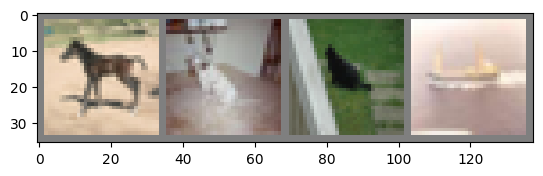

horse dog cat ship


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download CIFAR-10
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Visualize examples
classes = train_set.classes
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_loader_preview = DataLoader(train_set, batch_size=4, shuffle=True)
dataiter = iter(train_loader_preview)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))


#### Split data (90% train data)

In [3]:
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [4]:
writer = SummaryWriter('runs/resnet18_cifar10')

#### Initialize ResNet-18

In [5]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

C:\Users\yardh\anaconda3\envs\tens_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yardh\anaconda3\envs\tens_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model train function
This funciton trains and validates the model on the CIFAR-10 dataset. The loss and accuracy are tracked for both training and validation in each epoch (25 epochs).

In [7]:
def train_model(model, epochs=25):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    best_val_acc = 0
    best_metrics = {}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_metrics = {
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_acc': train_accuracy,
                'val_acc': val_accuracy
            }

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.3f}, Val Acc: {val_accuracy:.2f}%')

        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    return history, best_metrics


#### Model evaluation function

In [8]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    return acc, all_preds, all_labels


#### Train model for 25 epochs

In [9]:
# Train the model and store history
history_c10, best_metrics_c10 = train_model(model, epochs=25)

# Evaluate on test set and gather predictions
test_acc, test_preds, test_labels = evaluate_model(model, test_loader)

results_c10 = {
    'test_acc': test_acc,
    'test_loss': 0.0,
    'labels': test_labels,
    'predictions': test_preds
}

DATASET_NAME_C10 = "CIFAR-10"
class_names_c10 = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]


Epoch 1, Train Loss: 1.415, Train Acc: 49.16%, Val Loss: 1.112, Val Acc: 61.04%
Epoch 2, Train Loss: 1.021, Train Acc: 63.96%, Val Loss: 1.038, Val Acc: 63.62%
Epoch 3, Train Loss: 0.832, Train Acc: 71.09%, Val Loss: 0.882, Val Acc: 69.36%
Epoch 4, Train Loss: 0.713, Train Acc: 75.28%, Val Loss: 0.839, Val Acc: 71.52%
Epoch 5, Train Loss: 0.601, Train Acc: 79.28%, Val Loss: 0.794, Val Acc: 73.32%
Epoch 6, Train Loss: 0.508, Train Acc: 82.45%, Val Loss: 0.785, Val Acc: 74.50%
Epoch 7, Train Loss: 0.414, Train Acc: 85.50%, Val Loss: 0.789, Val Acc: 75.14%
Epoch 8, Train Loss: 0.340, Train Acc: 88.00%, Val Loss: 0.801, Val Acc: 74.76%
Epoch 9, Train Loss: 0.271, Train Acc: 90.65%, Val Loss: 0.864, Val Acc: 76.10%
Epoch 10, Train Loss: 0.223, Train Acc: 92.27%, Val Loss: 0.891, Val Acc: 75.52%
Epoch 11, Train Loss: 0.182, Train Acc: 93.73%, Val Loss: 0.949, Val Acc: 76.94%
Epoch 12, Train Loss: 0.149, Train Acc: 94.76%, Val Loss: 1.018, Val Acc: 75.10%
Epoch 13, Train Loss: 0.139, Train Ac

#### Loss/accuracy curves and confusion matrix

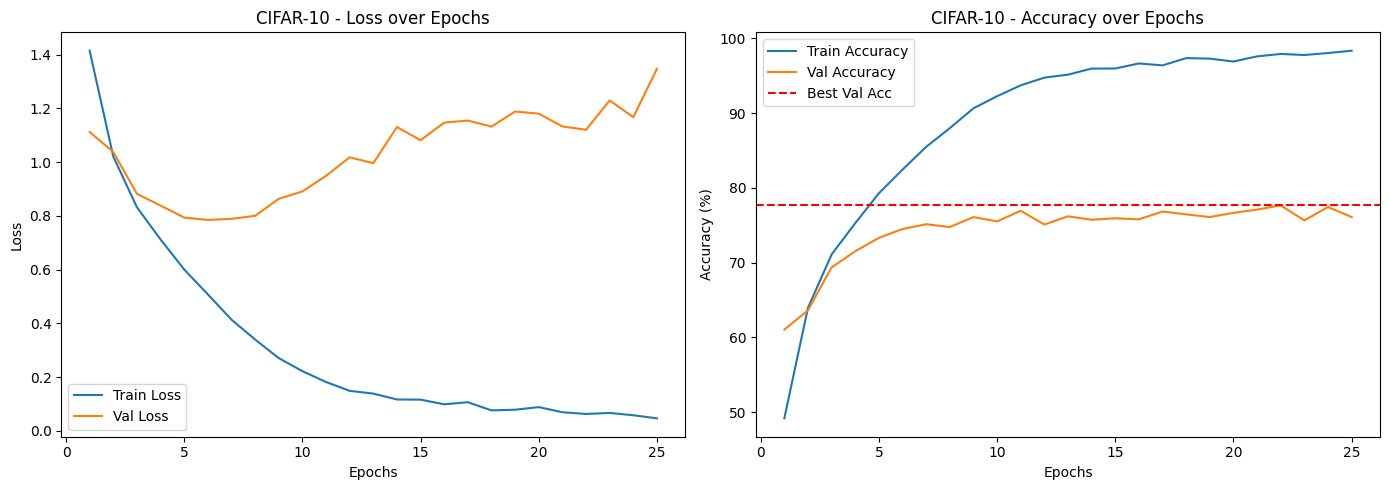

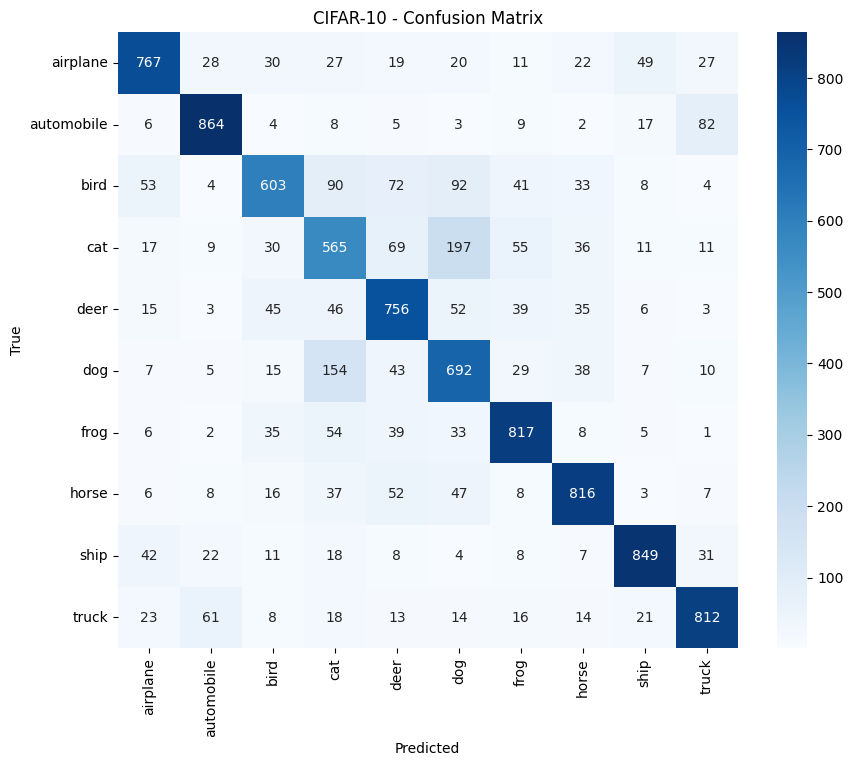


--- CIFAR-10 Metrics ---
Best Training Accuracy: 97.93%
Best Validation Accuracy: 77.66%
Final Test Accuracy: 75.41%


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_history(history, best_metrics, dataset_name="Dataset"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Loss over Epochs')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.axhline(y=best_metrics['val_acc'], color='r', linestyle='--', label='Best Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{dataset_name} - Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, class_names, dataset_name="Dataset"):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

def print_metrics_summary(results, dataset_name, best_metrics):
    print(f"\n--- {dataset_name} Metrics ---")
    print(f"Best Training Accuracy: {best_metrics['train_acc']:.2f}%")
    print(f"Best Validation Accuracy: {best_metrics['val_acc']:.2f}%")
    print(f"Final Test Accuracy: {results['test_acc']:.2f}%")

plot_history(history_c10, best_metrics_c10, DATASET_NAME_C10)
plot_confusion_matrix(test_labels, test_preds, class_names_c10, DATASET_NAME_C10)
print_metrics_summary(results_c10, DATASET_NAME_C10, best_metrics_c10)


In [13]:
transform_fashion = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_train_set = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                      download=True, transform=transform_fashion)

fashion_test_set = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                     download=True, transform=transform_fashion)

fashion_classes = fashion_train_set.classes


In [14]:
train_size_fashion = int(0.9 * len(fashion_train_set))
val_size_fashion = len(fashion_train_set) - train_size_fashion
fashion_train_subset, fashion_val_subset = random_split(fashion_train_set, [train_size_fashion, val_size_fashion])

fashion_train_loader = DataLoader(fashion_train_subset, batch_size=64, shuffle=True)
fashion_val_loader = DataLoader(fashion_val_subset, batch_size=64, shuffle=False)
fashion_test_loader = DataLoader(fashion_test_set, batch_size=64, shuffle=False)


In [15]:
writer_fashion = SummaryWriter('runs/resnet18_fashionmnist')

model_fashion = models.resnet18(pretrained=False)
model_fashion.fc = nn.Linear(model_fashion.fc.in_features, 10)
model_fashion = model_fashion.to(device)

criterion_fashion = nn.CrossEntropyLoss()
optimizer_fashion = optim.Adam(model_fashion.parameters(), lr=0.001)


C:\Users\yardh\anaconda3\envs\tens_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yardh\anaconda3\envs\tens_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
def train_model_fashion(model, epochs=25):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    best_val_acc = 0
    best_metrics = {}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in fashion_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer_fashion.zero_grad()
            outputs = model(images)
            loss = criterion_fashion(outputs, labels)
            loss.backward()
            optimizer_fashion.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(fashion_train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in fashion_val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion_fashion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(fashion_val_loader)
        val_accuracy = 100 * correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_metrics = {
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_acc': train_accuracy,
                'val_acc': val_accuracy
            }

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.3f}, Val Acc: {val_accuracy:.2f}%')

        writer_fashion.add_scalar('Loss/train', avg_train_loss, epoch)
        writer_fashion.add_scalar('Loss/val', avg_val_loss, epoch)
        writer_fashion.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer_fashion.add_scalar('Accuracy/val', val_accuracy, epoch)

    return history, best_metrics


In [17]:
history_fashion, best_metrics_fashion = train_model_fashion(model_fashion, epochs=25)
test_acc_fashion, test_preds_fashion, test_labels_fashion = evaluate_model(model_fashion, fashion_test_loader)

results_fashion = {
    'test_acc': test_acc_fashion,
    'test_loss': 0.0,
    'labels': test_labels_fashion,
    'predictions': test_preds_fashion
}


Epoch 1, Train Loss: 0.439, Train Acc: 83.87%, Val Loss: 0.348, Val Acc: 86.93%
Epoch 2, Train Loss: 0.319, Train Acc: 88.29%, Val Loss: 0.312, Val Acc: 88.72%
Epoch 3, Train Loss: 0.279, Train Acc: 89.61%, Val Loss: 0.275, Val Acc: 90.07%
Epoch 4, Train Loss: 0.253, Train Acc: 90.58%, Val Loss: 0.255, Val Acc: 90.77%
Epoch 5, Train Loss: 0.234, Train Acc: 91.26%, Val Loss: 0.264, Val Acc: 90.67%
Epoch 6, Train Loss: 0.216, Train Acc: 91.97%, Val Loss: 0.257, Val Acc: 90.62%
Epoch 7, Train Loss: 0.205, Train Acc: 92.34%, Val Loss: 0.243, Val Acc: 91.48%
Epoch 8, Train Loss: 0.184, Train Acc: 93.05%, Val Loss: 0.239, Val Acc: 91.70%
Epoch 9, Train Loss: 0.168, Train Acc: 93.64%, Val Loss: 0.265, Val Acc: 90.73%
Epoch 10, Train Loss: 0.157, Train Acc: 94.07%, Val Loss: 0.260, Val Acc: 91.27%
Epoch 11, Train Loss: 0.141, Train Acc: 94.66%, Val Loss: 0.249, Val Acc: 91.52%
Epoch 12, Train Loss: 0.131, Train Acc: 95.04%, Val Loss: 0.250, Val Acc: 91.75%
Epoch 13, Train Loss: 0.119, Train Ac

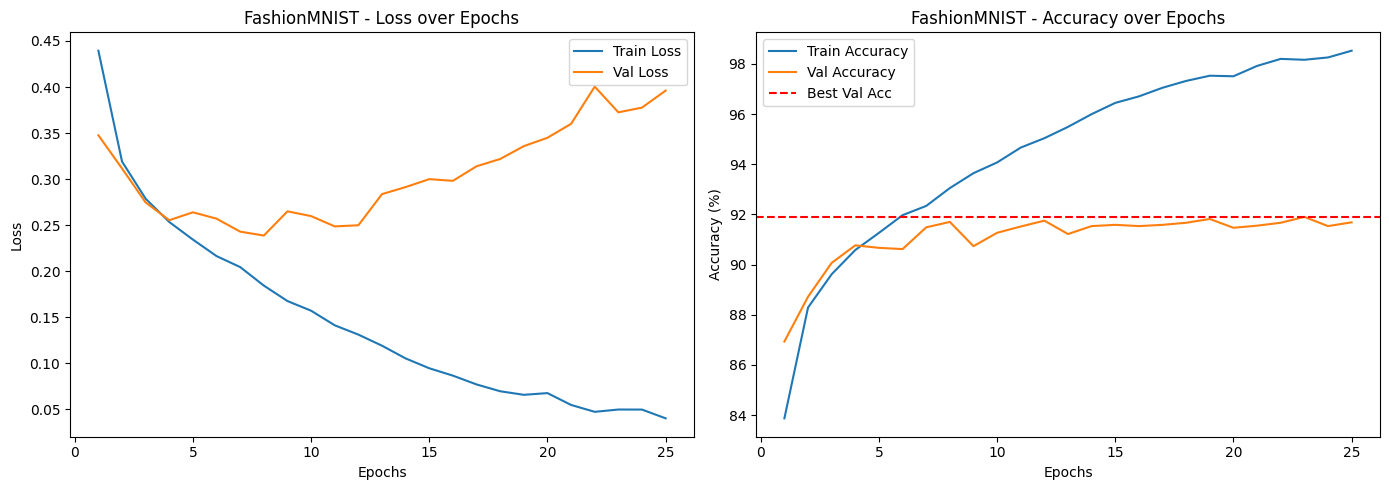

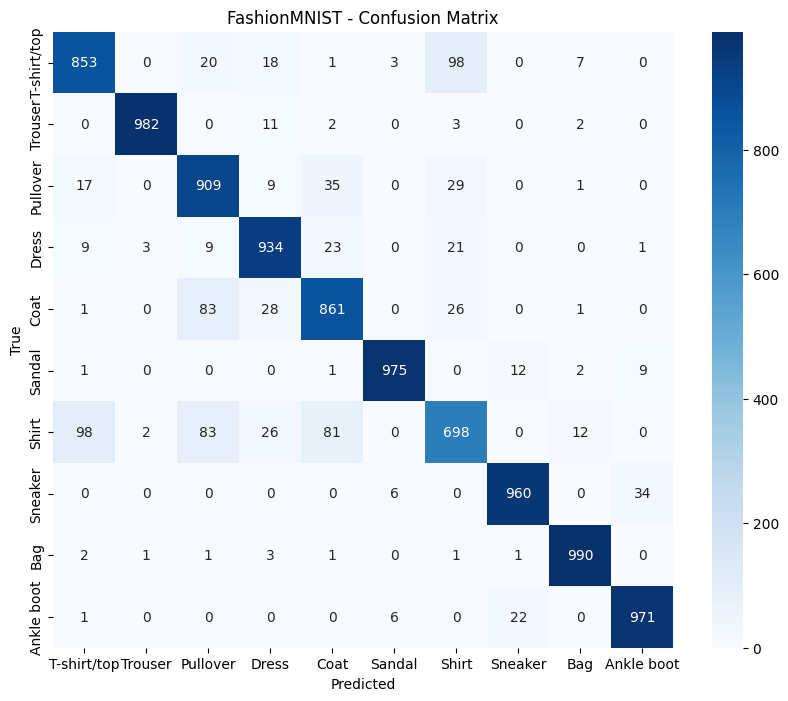


--- FashionMNIST Metrics ---
Best Training Accuracy: 98.16%
Best Validation Accuracy: 91.90%
Final Test Accuracy: 91.33%


In [18]:
DATASET_NAME_FASHION = "FashionMNIST"

plot_history(history_fashion, best_metrics_fashion, DATASET_NAME_FASHION)
plot_confusion_matrix(test_labels_fashion, test_preds_fashion, fashion_classes, DATASET_NAME_FASHION)
print_metrics_summary(results_fashion, DATASET_NAME_FASHION, best_metrics_fashion)
